# 1.1 Load BTC-EUR price data

In [1]:
# IMPORTS FOR SCRIPT
import pandas as pd
import numpy as np
import calendar
import datetime
import math 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.mode.chained_assignment = None

pd.set_option('max_rows', None)  #if required to see all results

In [2]:
# Import price dataframes - note use prepare_trade_data.py on coinbase_BTC_EUR.csv prior to running this notebook
df = pd.read_csv('btc_eur_ohlc_4h.csv')
df_1d = pd.read_csv('btc_eur_ohlc_1d.csv')

# Convert date in 'Timestamp' column from strftime to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%Y/%m/%d %H:%M")
df_1d['Timestamp'] = pd.to_datetime(df_1d['Timestamp'], format="%Y/%m/%d %H:%M")

In [3]:
# Specify cut-off point for data
year_start = 2017
year_end = 2018
# 4h
#df = df.loc[df['Timestamp'].dt.year >= years_selected,:]
df = df.loc[(df['Timestamp'].dt.year >= year_start)&(df['Timestamp'].dt.year <= year_end),:]
df_reset = df

# 1 Day
df_1d = df_1d.loc[(df_1d['Timestamp'].dt.year >= year_start)&(df_1d['Timestamp'].dt.year <= year_end),:]
df_1d_reset = df_1d

In [4]:
df = df_1d.copy()
df.head()

,Timestamp,open,high,low,close,Volume_BTC
617,2017-01-01,924.99,953.69,921.47,948.07,477.632210
618,2017-01-02,948.66,988.58,945.20,975.00,877.615804
619,2017-01-03,975.01,990.00,964.66,988.65,843.342754
620,2017-01-04,987.05,1098.71,983.76,1082.77,1295.132021
621,2017-01-05,1082.99,1111.56,833.66,955.66,2652.199224


# 1.3 Explore indicators

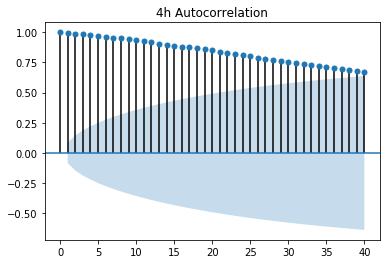

In [8]:
# Plot autocorrelation of close price
# Sample 2015-2018, significance is 400 periods (c. 2 months)
# Sample 2016-2018, significance is 400 periods (c. 2 months)
# Sample 2017/2018, significance is 240 periods (c. 1 month)
# Sample 2015, significance is 100 periods (c. 2 weeks)
# Sample 2016, significance is 160 periods (c. 3 weeks)
# Sample 2017, significance is 140 periods (c. 3 weeks)
# Sample partial-2018, significance is 50 periods (c. 1 week)

from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
series = df['close']
# plot_acf(series,lags=len(series)-1, alpha=0.05, title='4h Autocorrelation')
plot_acf(series,lags=40, alpha=0.05, title='4h Autocorrelation')
plt.show();

Price is not random. There are emerging trends over time. The time series is autocorrelated for c. 2 months.

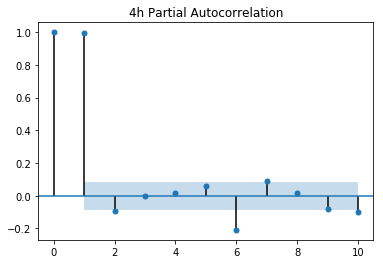

In [32]:
# Plot partial autocorrelation - close price 
# Sample 2017/2018, significance is 2 periods (8 hours)
# Sample 2017, significance is 1 periods (8 hours)
# Sample partial-2018, significance is 2 periods (8 hours)
from statsmodels.graphics.tsaplots import plot_pacf
series = df['close']
plot_pacf(series, lags=10,alpha=0.05, title='4h Partial Autocorrelation')
plt.show()

In [19]:
df.dropna(inplace=True)
print(df.shape)
df.head()

(540, 6)


,Timestamp,open,high,low,close,Volume_BTC
Timestamp,,,,,,
2017-01-01,2017-01-01,924.99,953.69,921.47,948.07,477.632210
2017-01-02,2017-01-02,948.66,988.58,945.20,975.00,877.615804
2017-01-03,2017-01-03,975.01,990.00,964.66,988.65,843.342754
2017-01-04,2017-01-04,987.05,1098.71,983.76,1082.77,1295.132021
2017-01-05,2017-01-05,1082.99,1111.56,833.66,955.66,2652.199224


# 2.1 Time Series Prediction

In [11]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%Y/%m/%d")
df.index = df['Timestamp']

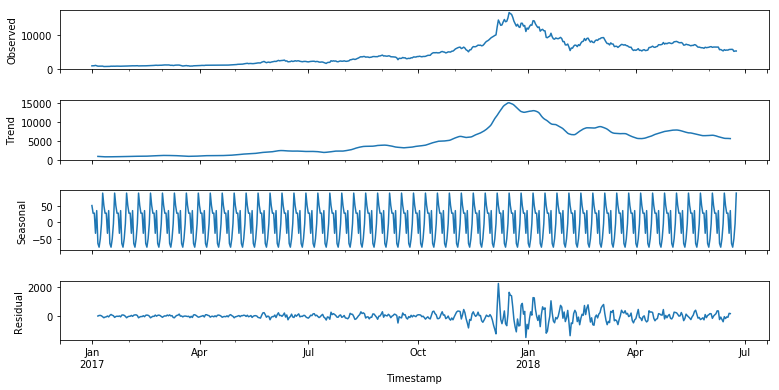

In [16]:
# Set the frequency of the model to be about a week
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['close'], freq=10)
fig = decomposition.plot()
fig.set_size_inches(12, 6)

plt.show()

In [18]:
print(df['close'].index.min(), df['close'].index.max())

2017-01-01 00:00:00 2018-06-24 00:00:00


In [20]:
# let's use "up to Feb 2018" as the training set and the rest as test, so we incorporate one Christmas forecast
train = df['close'][:"2018-04-30"]
test = df['close']["2018-05-01":]
print(len(train), len(test))

485 55


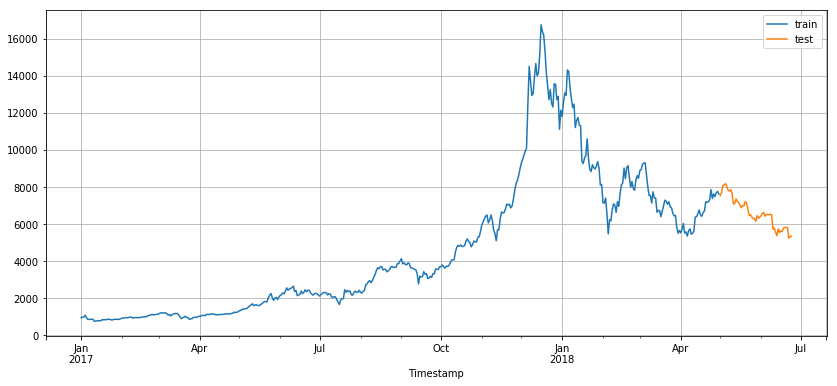

In [21]:
fig, ax = plt.subplots(figsize=(14, 6))

train.plot(ax=ax, label="train")
test.plot(ax=ax, label="test", grid=True)
ax.legend()

plt.show()

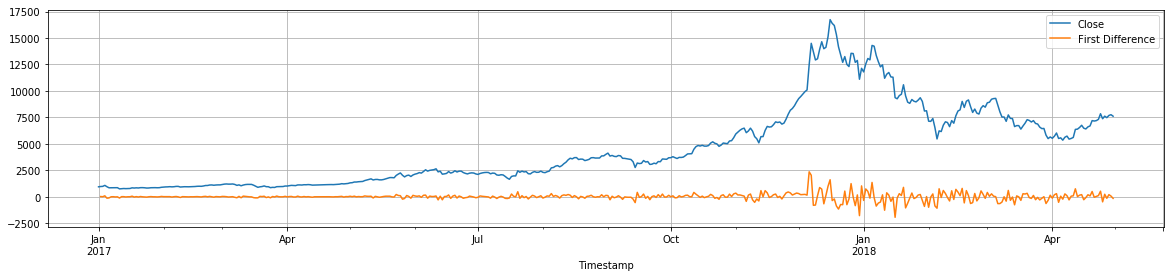

In [22]:
# Check for stationarity
first_diff = train.diff(periods = 1)

fig, ax = plt.subplots(figsize=(20, 4))
train.plot(label="Close")
first_diff.plot(label="First Difference", grid=True)
ax.legend()
plt.show()

In [23]:
# Check for stationarity
first_diff_clean = first_diff.dropna()
from statsmodels.tsa.stattools import adfuller

adfuller(first_diff_clean)

(-4.430709772880872,
 0.00026181002745873414,
 18,
 465,
 {'1%': -3.4444914328761977,
  '10%': -2.570091378194011,
  '5%': -2.8677756786103683},
 6773.373688538485)

In [24]:
import statsmodels as sm                                          # sm.__version__
from statsmodels.tsa.arima_model import ARIMA
import datetime

In [25]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(3,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=7610.749379, expected=7534.990000
predicted=7536.668516, expected=7699.990000
predicted=7735.483575, expected=8068.120000
predicted=8122.121570, expected=8105.010000
predicted=8109.186752, expected=8179.480000
predicted=8169.190907, expected=8020.010000
predicted=8017.790832, expected=7819.000000
predicted=7841.867197, expected=7768.910000
predicted=7799.789301, expected=7854.910000
predicted=7868.798124, expected=7639.010000
predicted=7613.007783, expected=7075.010000
predicted=7036.083091, expected=7110.000000
predicted=7155.569136, expected=7348.490000
predicted=7419.470759, expected=7212.690000
predicted=7233.176901, expected=7160.800000
predicted=7161.691089, expected=7022.950000
predicted=6997.214702, expected=6876.520000
predicted=6925.667492, expected=7000.000000
predicted=7035.249155, expected=6978.620000
predicted=7002.350762, expected=7216.790000
predicted=7200.192280, expected=7132.050000
predicted=7140.077311, expected=6787.000000
predicted=6763.357920, expected=

In [26]:
# Accuracy check
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
print ('As % of mean:', rmse/test.mean()*100)

Test RMSE: 213.898
As % of mean: 3.236634070856205


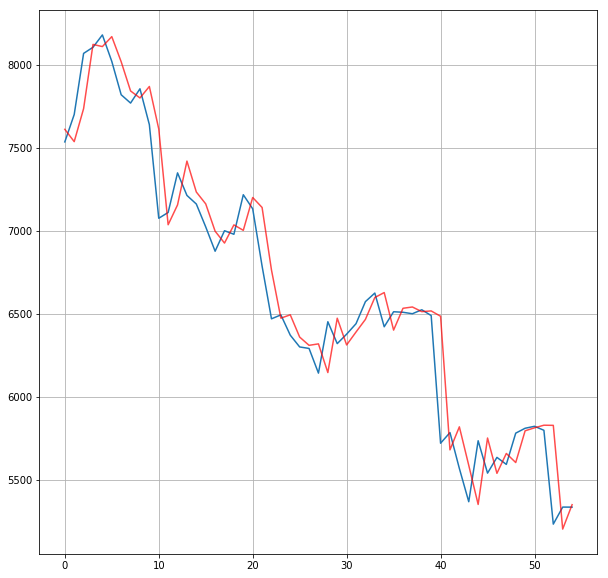

In [27]:
from matplotlib import pyplot
plt.figure(figsize=(10,10))
pyplot.plot(test.tolist())
pyplot.plot(predictions, color='red', alpha=0.7)
pyplot.grid()
pyplot.show()

In [28]:
predictions_series = pd.Series([i for x in predictions for i in x], index=test.index)

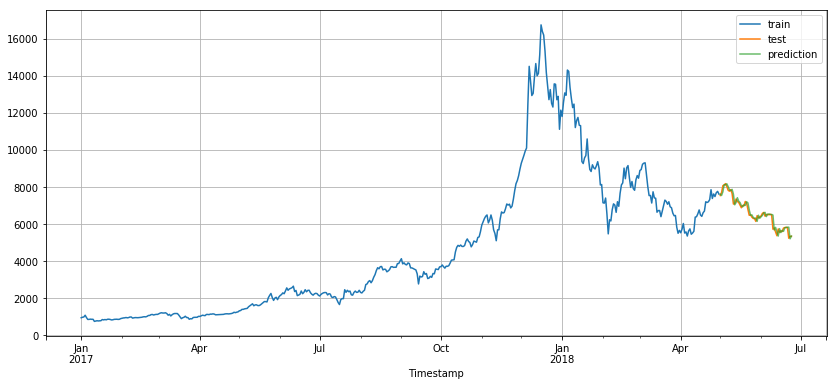

In [29]:
fig, ax = plt.subplots(figsize=(14, 6))

train.plot(ax=ax, label="train")
test.plot(ax=ax, label="test")
predictions_series.plot(ax=ax, label="prediction", alpha=0.7)
pyplot.grid()
ax.legend()

plt.show()

<b> try generalise to future

In [30]:
df.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2018-06-15', '2018-06-16', '2018-06-17', '2018-06-18',
               '2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22',
               '2018-06-23', '2018-06-24'],
              dtype='datetime64[ns]', name='Timestamp', length=540, freq=None)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


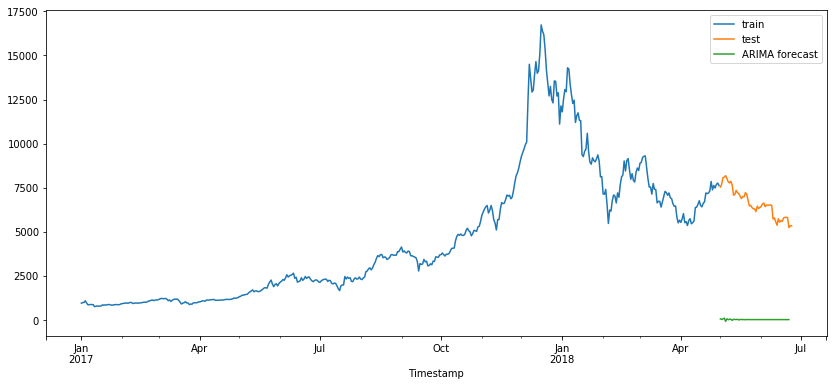

In [39]:
import statsmodels as sm                                          # sm.__version__
from statsmodels.tsa.arima_model import ARIMA
import datetime

# model = sm.tsa.SARIMAX(train, order=(3, 1, 0).fit()
model = ARIMA(train, order=(10,1,1)).fit()
y_pred = model.predict(start='2018-05-01', end='2018-06-22')

fig, ax = plt.subplots(figsize=(14, 6))

train.plot(ax=ax, label="train")
test.plot(ax=ax, label="test")
y_pred.plot(ax=ax, label="ARIMA forecast")
ax.legend()

plt.show()